# Part 1 : Logistic regretion

## I - Imports

In [1]:
%pip install xlrd
%pip install numpy 
%pip install pandas 
%pip install seaborn 
%pip install openpyxl 
%pip install matplotlib 
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_score, recall_score, f1_score

## II - Data Loading

In [3]:
path = "./data/default of credit card clients.xls"
data = pd.read_excel(path, header=1)  

# I skipped the first row as the column headers are on the second one

## III - Overview

### A. In numbers

In [4]:
# Here I try to see if I can find any obvious defects in the dataset

print('Data information : \n')
print(f"{data.info()}\n")

print('Data depiction : \n')
print(f"{data.describe()}\n")

print('Amount of null values : \n')
print(f"{data.isnull().sum()}\n")

Data information : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-nu

### B. In graphs

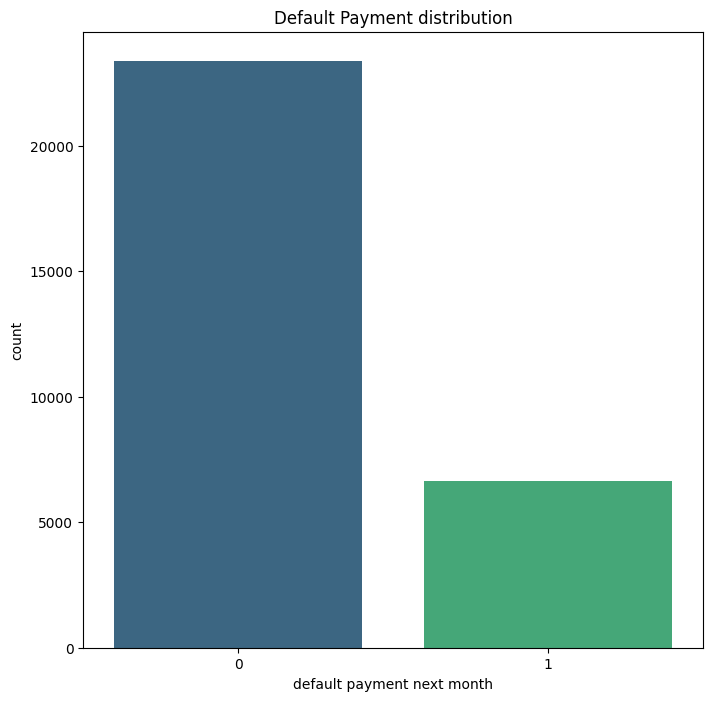

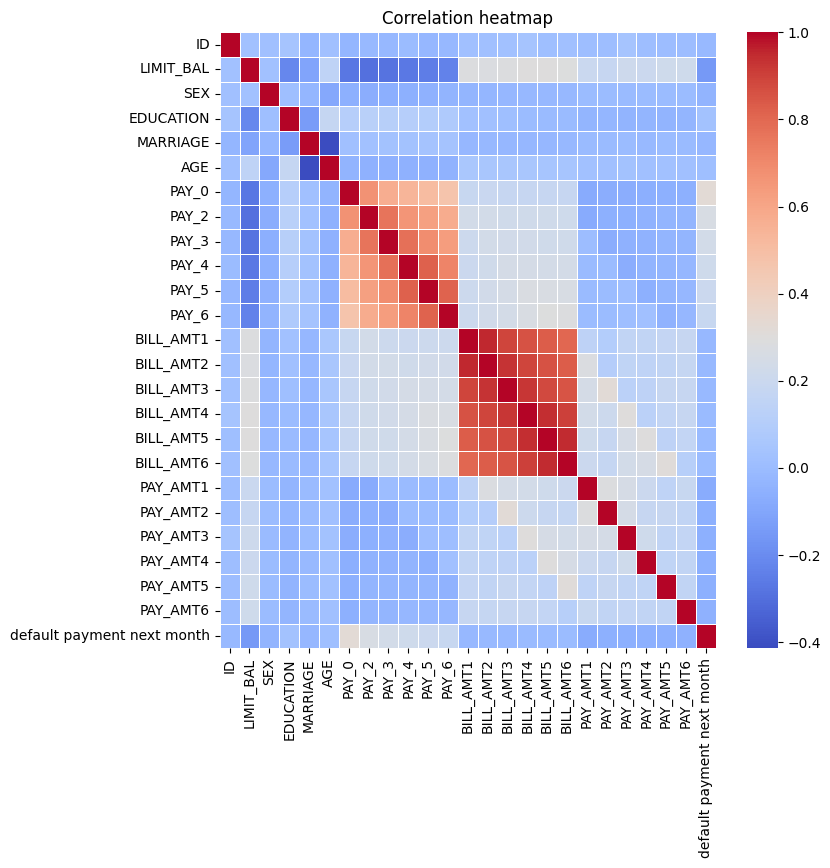

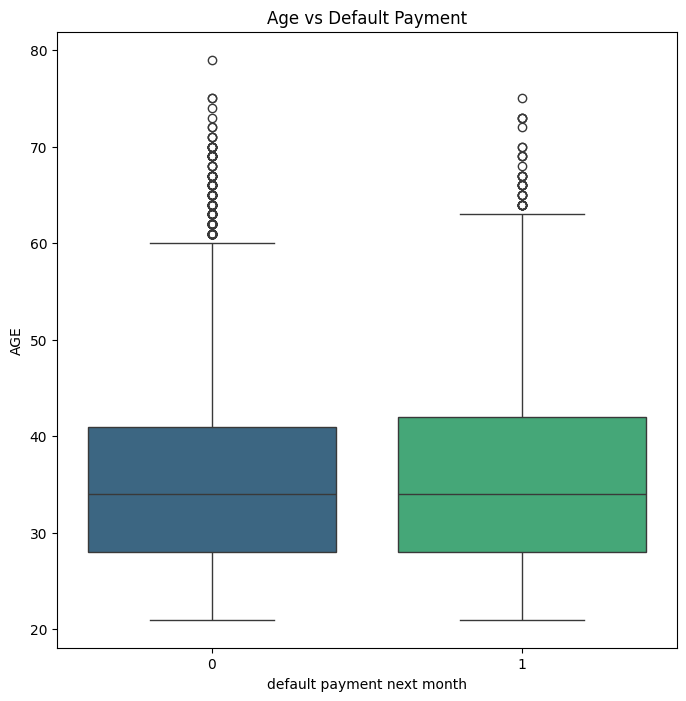

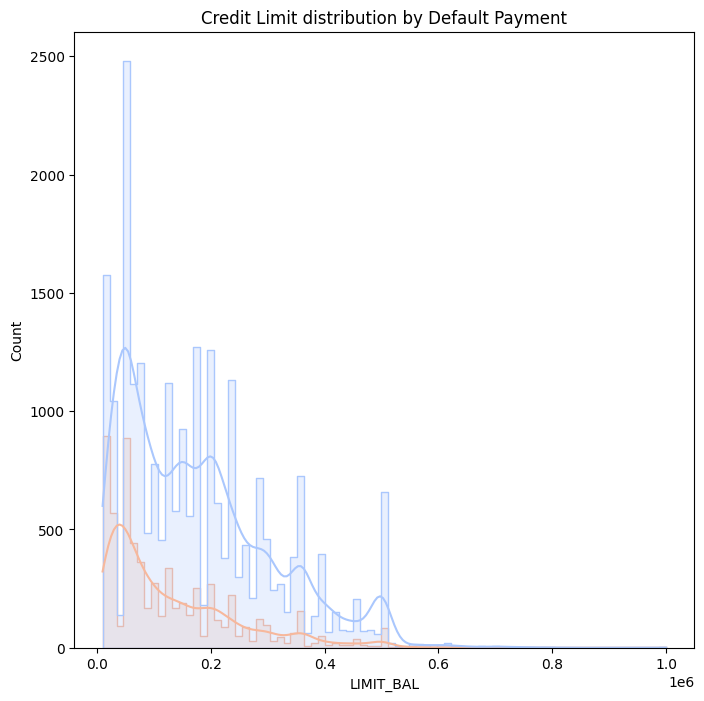

In [5]:
warnings.filterwarnings("ignore")

FIG_SIZE = (8, 8)

### Graph 1: Default Payment distribution ###

plt.figure(figsize=FIG_SIZE)
sns.countplot(x="default payment next month", data=data, palette="viridis", dodge=False)

plt.title("Default Payment distribution")
plt.show()

### Graph 2: Correlation heatmap ###

corr = data.corr()

plt.figure(figsize=FIG_SIZE)
plt.title("Correlation heatmap")

sns.heatmap(corr, annot=False, cmap="coolwarm", linewidths=0.5)
plt.show()

### Graph 3: Age vs Default Payment ###

plt.figure(figsize=FIG_SIZE)
sns.boxplot(x="default payment next month", y="AGE", data=data, hue="default payment next month",  palette="viridis", legend=False)

plt.title("Age vs Default Payment")
plt.show()

### Graph 4: Credit Limit vs Default Payment ###

plt.figure(figsize=FIG_SIZE)
sns.histplot(data=data, x="LIMIT_BAL", hue="default payment next month",   kde=True, element="step", palette="coolwarm", legend=False)

plt.title("Credit Limit distribution by Default Payment")
plt.show()

## IV - Preprocessing

We will not take the *SEX* column of our dataset into account as it would promote **unfairness** in the calculation of credit loan scores :

Illegal under American (**ECOA**) and European laws (**GDPR**)

Under US governance, taking into account *Marital status*, *Age* and *Education* could also be considered as unfair. I choose, in the context of this study, to keep them anyway

In [6]:
# I separate the features in two different types

numerical_features = [
    "LIMIT_BAL", "AGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", 
    "BILL_AMT6","PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", 
    "PAY_AMT5", "PAY_AMT6"]

non_numerical_features = ["EDUCATION", "MARRIAGE"]

Here I will instantiate two different **preprocessing pipelines** for our two data types (numerical and non-numerical) :

- The **numerical_transformer** will use :

*SimpleImputer* to replace missing values (if there are any) by the median value of the column

*StandardScaler* to standardize the values

- The **non_numerical_transformer** will use :

*SimpleImputer* to replace missing values (if there are any) by the most frequent value of the column

*OneHotEncoder* to convert the values (that are not numbers) into binary indicators

In [7]:
# Pipeline 1
numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("standardscaler", StandardScaler())])

# Pipeline 2
non_numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("onehotencoder", OneHotEncoder(handle_unknown="ignore"))])

# Pipeline Manager
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("non_num", non_numerical_transformer, non_numerical_features)])


These two pipelines will be controlled by the **ColumnTransformer** and used as a a single preprocessing step.

## V - Data Splitting

In [8]:
# I keep only the features in the X variable (thus we remove the id and the label)
# I also remove SEX as part of the features

X = data.drop(columns=["ID", "SEX", "default payment next month"])
Y = data["default payment next month"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=13, stratify=Y)

# The labels are close to be considered as imbalanced :
# To improve the accuracy I could apply a SWOTE method to re-balance the classes

# smote = SMOTE(random_state=13)
# X_train, y_train = smote.fit_resample(X_train, y_train)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000,))])

# I then apply cross-validation to the model

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")

Cross-Validation AUC Scores: 
[0.73736081 0.7355413  0.70388533 0.71850839 0.72877954]


## VI - Model Building

### A. Training

In [9]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

The *predict* method gives only the final classification result  (0 or 1) based on the default threshold

It does not provide any information about the **model's certainty**, we thus also use the *predict_proba* method

In scenarios like **credit scoring** or **risk assessment**, probabilities help to rank instances based on their likelihood of belonging to a certain class 

### B. Evaluation

In [10]:
print("Accuracy:")
print(f"{accuracy_score(y_test, y_pred):.4f}\n")

print("ROC - AUC:")
print(f"{roc_auc_score(y_test, y_pred_prob):.4f}\n")

print("Precision:")
print(f"{precision_score(y_test, y_pred):.4f}\n")

print("Recall:")
print(f"{recall_score(y_test, y_pred):.4f}\n")

print("F1-Score:")
print(f"{f1_score(y_test, y_pred):.4f}\n")

print("Overall Report:")
print(classification_report(y_test, y_pred))

Accuracy:
0.8060

ROC - AUC:
0.7161

Precision:
0.6983

Recall:
0.2163

F1-Score:
0.3303

Overall Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.89      4673
           1       0.70      0.22      0.33      1327

    accuracy                           0.81      6000
   macro avg       0.76      0.59      0.61      6000
weighted avg       0.79      0.81      0.76      6000



### C. Visualisation

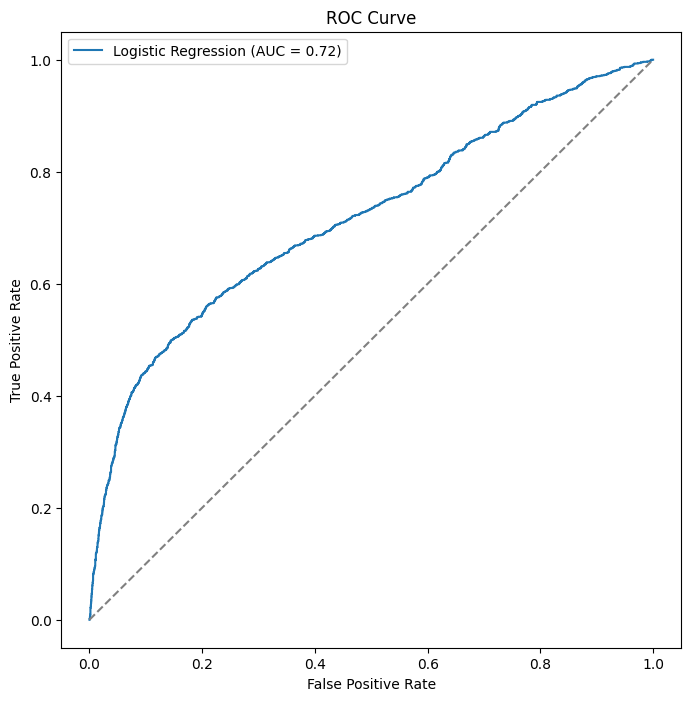

In [11]:
# I assess, here, the numbers of false positive and true positive

fp, tp, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=FIG_SIZE)

plt.plot(fp, tp, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC Curve")
plt.legend()
plt.show()

### D. Feature Importance

To have a little more room for interpretation we can check the importance of certain features

Let's do this using a *RandomForestClassifier*

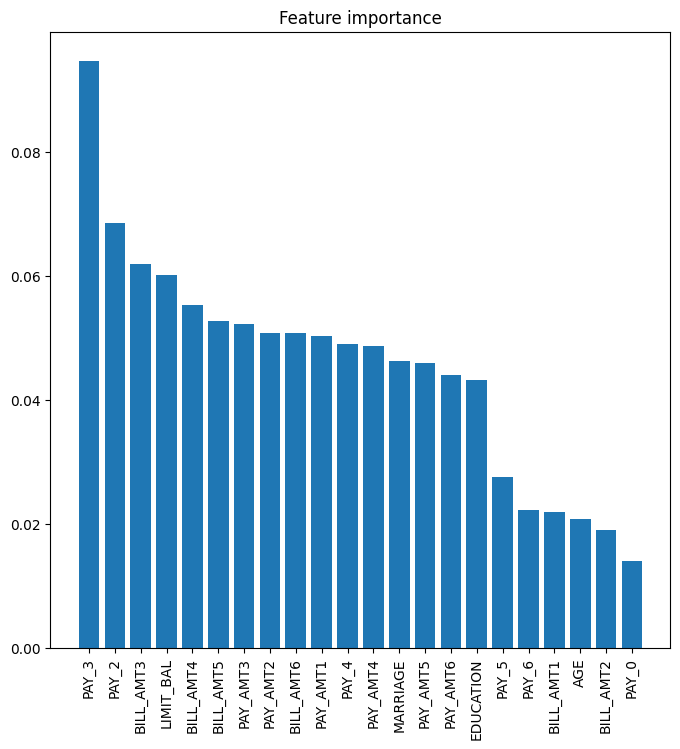

In [12]:
rf_model = RandomForestClassifier(random_state=13)
rf_model.fit(X_train, y_train)

# I extract the values from the fitted model

importances = rf_model.feature_importances_
f_names = numerical_features + list(pd.get_dummies(data[non_numerical_features]).columns)

# I now sort the features by their respective impact

sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=FIG_SIZE)

plt.bar(range(len(importances)), importances[sorted_indices], align="center")
plt.xticks(range(len(importances)), [f_names[i] for i in sorted_indices], rotation=90)

plt.title("Feature importance")
plt.show()

# Part 2 : XGBoost

## I - Imports 

In [13]:
%pip install optuna
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [14]:
import xgboost as xgb

from sklearn.model_selection import ParameterGrid

There are issues with these two imports :

*from xgboost import XGBClassifier*

*from sklearn.model_selection import GridSearchCV, StratifiedKFold*

We thus use **xgboost** and its built-in **cross validation**

## II - Model Building

### A. Setup

In [15]:
d_matrix = xgb.DMatrix(X_train, label=y_train)

### B. Training & Optimisation

The goal of this section is to find the highest **AUC (*Area Under the Curve*)**

The closer it gets to 1 the more performant our model is :

- We, thus, try all combinations of hyperparameters and save the one offering the best score

With a good machine this section might take a while to complete as it averages **6 min**
(could be optimised with *RandomSearchCV* or the *optuna* library)

In [16]:
# I create a dictionnary of some of the possible XGBoost hyperparameters

params = {
    "objective": ["binary:logistic"],
    "eval_metric": ["auc"],

    "eta": [0.01, 0.1, 0.3],
    "max_depth": [3, 5, 7],
    
    "subsample": [0.6, 0.8, 0.9],
    "colsample_bytree": [0.6, 0.8, 0.9],
    
    "tree_method": ["gpu_hist"]}

best_auc = 0 
best_params = None
grid = list(ParameterGrid(params))

# I apply a cross validation from the xgboost library and iterate on each possibilities

for params in grid:

    cv_results = xgb.cv(

        params,
        d_matrix,
        num_boost_round=200,

        nfold=5,
        metrics="auc",
        as_pandas=True,

        seed=13)
    
    max_auc = cv_results["test-auc-mean"].max()

    # I then update the best hyperparameter set if the current AUC is better
    
    if max_auc > best_auc:
        best_auc = max_auc
        best_params = params

print("Best Hyperparameters:", best_params)
print("Best AUC:", best_auc)

optimal_boost_rounds = cv_results["test-auc-mean"].idxmax() + 1
print(f"\nOptimal Boosting Rounds:  {optimal_boost_rounds}\n")

Best Hyperparameters: {'colsample_bytree': 0.8, 'eta': 0.1, 'eval_metric': 'auc', 'max_depth': 5, 'objective': 'binary:logistic', 'subsample': 0.9, 'tree_method': 'gpu_hist'}
Best AUC: 0.7857497737765596

Optimal Boosting Rounds:  8



### C. Prediction

In [17]:
xgb_model = xgb.train(best_params, dtrain=d_matrix, num_boost_round=optimal_boost_rounds)

# Just like logistic regretion, I use a test set and make predictions on it

d_test = xgb.DMatrix(X_test)

y_pred_xgb = (xgb_model.predict(d_test) >= 0.5).astype(int)
y_pred_prob_xgb = xgb_model.predict(d_test)

### D. Evaluation

In [18]:
print("XGBoost Accuracy:")
print(f"{accuracy_score(y_test, y_pred_xgb):.4f}\n")

print("XGBoost ROC - AUC:")
print(f"{roc_auc_score(y_test, y_pred_prob_xgb):.4f}\n")

print("XGBoost Precision:")
print(f"{precision_score(y_test, y_pred_xgb):.4f}\n")

print("XGBoost Recall:")
print(f"{recall_score(y_test, y_pred_xgb):.4f}\n")

print("XGBoost F1-Score:")
print(f"{f1_score(y_test, y_pred_xgb):.4f}\n")

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy:
0.8010

XGBoost ROC - AUC:
0.7622

XGBoost Precision:
0.7806

XGBoost Recall:
0.1394

XGBoost F1-Score:
0.2366

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      4673
           1       0.78      0.14      0.24      1327

    accuracy                           0.80      6000
   macro avg       0.79      0.56      0.56      6000
weighted avg       0.80      0.80      0.74      6000



### E. Visualisation

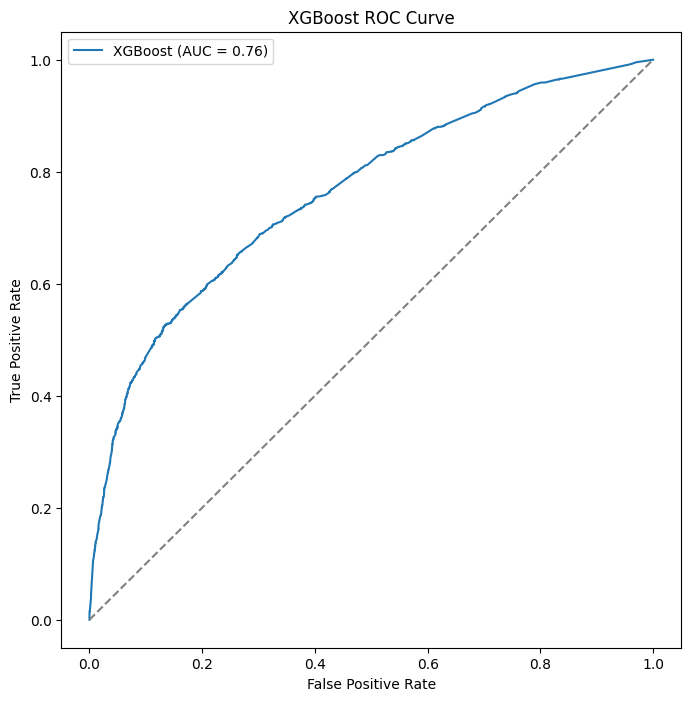

In [19]:
fp_xgb, tp_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)

plt.figure(figsize=FIG_SIZE)

plt.plot(fp_xgb, tp_xgb, label=f"XGBoost (AUC = {roc_auc_score(y_test, y_pred_prob_xgb):.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.show()

### F. Feature Importance & Validation

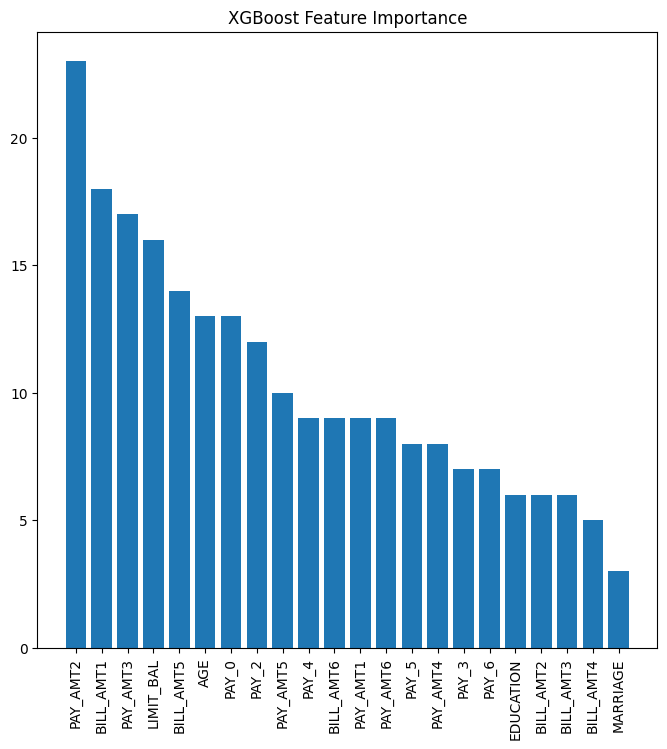

XGBoost Cross-Validation AUC Scores:
0      0.755317
1      0.769108
2      0.772299
3      0.771950
4      0.772574
         ...   
195    0.749230
196    0.749241
197    0.749068
198    0.749231
199    0.749234
Name: test-auc-mean, Length: 200, dtype: float64

Mean AUC: 0.7588196180678074
Standard Deviation AUC: 0.0076942164133711535


In [20]:
xgb_importances = xgb_model.get_score(importance_type="weight")
xgb_sorted_indices = sorted(xgb_importances, key=xgb_importances.get, reverse=True)

plt.figure(figsize=FIG_SIZE)

plt.bar(range(len(xgb_sorted_indices)), [xgb_importances[k] for k in xgb_sorted_indices], align="center")
plt.xticks(range(len(xgb_sorted_indices)), xgb_sorted_indices, rotation=90)

plt.title("XGBoost Feature Importance")
plt.show()


print("XGBoost Cross-Validation AUC Scores:")
print(cv_results["test-auc-mean"])

print("\nMean AUC:", cv_results["test-auc-mean"].mean())
print("Standard Deviation AUC:", cv_results["test-auc-mean"].std())

# Part 3 : Saving the models

In [21]:
import os
import joblib  

# I create a folder named 'Models' 

models_folder = "Models"

if not os.path.exists(models_folder):
    os.makedirs(models_folder)

# Saving the Logistic Regression model

logistic_model_path = os.path.join(models_folder, "logistic_regression_model.pkl")
joblib.dump(model, logistic_model_path)

print(f"Logistic Regression model saved at : {logistic_model_path}")

# Saving the XGBoost model

xgboost_model_path = os.path.join(models_folder, "xgboost_model.model")
xgb_model.save_model(xgboost_model_path)

print(f"XGBoost model saved at: {xgboost_model_path}")

Logistic Regression model saved at : Models\logistic_regression_model.pkl
XGBoost model saved at: Models\xgboost_model.model


# Part 4 : FICO Scores

We have saved models that can predict with a certain precision how likely will a client be given a default payment (based on the dataset given)

These two models output **probabilities** thus :

Let's define a function that translates these probabilities into **FICO** scores, a known indicator in the credit industry

| **FICO (*Fair Isaac Corporation*)** |

In [22]:
def calculate_fico_scores(pred, A = 850, B = 300):

    """
    Converts a probability into a FICO score
    
    Parameters:
        pred        : float (output of our ML model on credit loans)
        A           : float (upper bound of the FICO score)
        B           : float (lower bound of the FICO score)

    """

    odds = pred / (1 - pred)
    fico_score = A - B * np.log10(odds)

    return np.clip(fico_score, B, A) # I make sure the scores remain in the FICO range

The following function can be used to evaluate a person's credit risk based on their credit history. It can be used on the output of our two models

The FICO score being a 3 digit number (300 -> 850) representing a borrowers *creditworthiness* : it is used to calculate the likelyhood of that borrower repaying a loan.